# **Target Market Research of Bike Company**

## Perkenalan

Nama: Elia Oktaviani

Objective: Dapat mengaplikasikan pembelajaran NLP menggunakan ANN dari raw data hingga deployement model pada huggingface.

Problem: Sebagai salah satu bagian game developer company, perusahaan ingin memahami opini dan tanggapan user terhadap game yang sedang berada di pasar. Dilakukan analisis sentimen untuk membantu mengidentifikasi sentimen positif, negatif, netral, atau irrelevan dari ulasan user pada media sosial.

## Import Libraries

In [2]:
# Import Libraries

import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

from sklearn.metrics import classification_report


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data Loading

### Loading Data Train dan Validation

In [3]:
url = 'https://drive.google.com/uc?id=1l6l0cdKhNstcrOkXNaBUqaH-cPn-Y8GT'

#read csv data fron gdrive link
df = pd.read_csv(url, header=None, names=["id","entity","sentiment","tweet"])

# display the DataFrame
print(df)

         id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   
74681  9200       Nvidia  Positive   

                                                   tweet  
0      im getting on borderlands and i will murder yo...  
1      I am coming to the borders and I will kill you...  
2      im getting on borderlands and i will kill you ...  
3      im coming on borderlands and i will murder you...  
4      im getting on borderlands 2 and i will murder ...  
...                                                  ...  
74677  Just realized that the Windows partition of my...  
74678  Just realized that my Mac window partition is ...  
74679  Just 

### Loading Data Test

In [4]:
url_test = 'https://drive.google.com/uc?id=1VgiTlUgjHM2yDTn4wp4glhaBoqFsOC6v'

# Read CSV data from the Google Drive link
df_test = pd.read_csv(url_test, header=None, names=["id","entity","sentiment","tweet"])

# Display the DataFrame
print(df_test)

       id               entity   sentiment  \
0    3364             Facebook  Irrelevant   
1     352               Amazon     Neutral   
2    8312            Microsoft    Negative   
3    4371                CS-GO    Negative   
4    4433               Google     Neutral   
..    ...                  ...         ...   
995  4891  GrandTheftAuto(GTA)  Irrelevant   
996  4359                CS-GO  Irrelevant   
997  2652          Borderlands    Positive   
998  8069            Microsoft    Positive   
999  6960      johnson&johnson     Neutral   

                                                 tweet  
0    I mentioned on Facebook that I was struggling ...  
1    BBC News - Amazon boss Jeff Bezos rejects clai...  
2    @Microsoft Why do I pay for WORD when it funct...  
3    CSGO matchmaking is so full of closet hacking,...  
4    Now the President is slapping Americans in the...  
..                                                 ...  
995  ⭐️ Toronto is the arts and culture capital 

### Drop Kolom Yang Tidak Diperlukan

In [5]:
#keep only sentiment and tweet columns
cols = ['id','entity']
df.drop(cols, axis = 1, inplace = True)
df_test.drop(cols, axis = 1, inplace = True)

### Handle Missing Value



In [6]:
#check missing value
print('train & validation')
print(df.isnull().sum())
print('-'*100)
print('test')
print(df_test.isnull().sum())

train & validation
sentiment      0
tweet        686
dtype: int64
----------------------------------------------------------------------------------------------------
test
sentiment    0
tweet        0
dtype: int64


In [7]:
#drop data row with missing value
df.dropna(inplace=True)

In [8]:
df_test.dropna(inplace=True)

### Handle Duplicate Data

In [9]:
#check duplicate data
print('train & validation')
print(df.duplicated().sum())
print('-'*100)
print('test')
print(df_test.duplicated().sum())

train & validation
4227
----------------------------------------------------------------------------------------------------
test
1


In [10]:
#drop duplicate data row
df.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

### Check Handling Result

In [11]:
#check result
print('train & validation')
print("null values:","\n",df.isnull().sum())
print("duplicated values:",df.duplicated().sum())
print('-'*100)
print('test')
print("null values:","\n",df_test.isnull().sum())
print("duplicated values:",df_test.duplicated().sum())

train & validation
null values: 
 sentiment    0
tweet        0
dtype: int64
duplicated values: 0
----------------------------------------------------------------------------------------------------
test
null values: 
 sentiment    0
tweet        0
dtype: int64
duplicated values: 0


Data berhasil dirapihkan dari data yang kosong dan duplikat data, maka bisa lanjut ke bagian EDA.

## EDA (sebelum text preprocessing)

Dibuat dataframe khusus untuk eda, agar tidak mengubah data aslinya.

In [12]:
df_vis = df.copy()

### Melihat sebaran sentiment tweet


Dibuat visualisasi sebaran klasifikasi data sentiment untuk melihat keseimbangan jumlah data.

In [ ]:
 # count the occurrences of each sentiment
sentiment_counts = df_vis['sentiment'].value_counts()

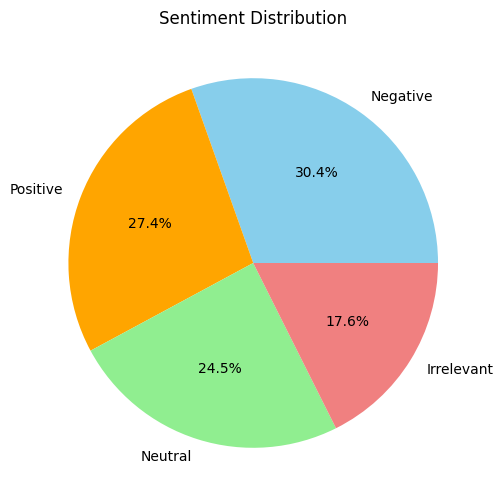

In [14]:
# plot the sentiment counts as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'orange', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution')
plt.show()

Dikatehui perbandingan data sentiment cukup tidak balance. Hal tersebut berpotensi menimbulkan overfitting karena model menjadi lebih familiar dengan data yang dominan. Tetapi imbalance masih tergolong tidak begitu jomplang, jadi masih bisa diterima.

### Melihat Gambaran Isi Tweet Setiap Sentiment

In [15]:
# print sample tweet

# pd.set_option('display_width', None)
sample_positive = df_vis[df_vis['sentiment']=='Positive'].sample(n=5)
sample_negative = df_vis[df_vis['sentiment']=='Negative'].sample(n=5)
sample_neutral = df_vis[df_vis['sentiment']=='Neutral'].sample(n=5)
sample_irrelevant = df_vis[df_vis['sentiment']=='Irrelevant'].sample(n=5)

# print the document sample
print('Sample Positive')
print('-'*100)
for doc in range(0,5):
  print(sample_positive.iloc[doc,1])
print('-'*100)

print('Sample Negative')
print('-'*100)
for doc in range(0,5):
  print(sample_negative.iloc[doc,1])
print('-'*100)

print('Sample Neutral')
print('-'*100)
for doc in range(0,5):
  print(sample_neutral.iloc[doc,1])
print('-'*100)

print('Sample Irrelevant')
print('-'*100)
for doc in range(0,5):
  print(sample_irrelevant.iloc[doc,1])
print('-'*100)

Sample Positive
----------------------------------------------------------------------------------------------------
Ppl see this once and think they know the whole goddamn game, like Fr shut himself the fuck up most of you kids who don say ’ t like play it so are fucking MW Made.
Johnson & Co report positive preclinical results at COVID-19 vaccine @JNJNews buff.ly/33abtFt
I find it interesting that everyone praises it for the originality of the genre, but Warcraft 3 mods, such as Murder at the Sleeping Town and Murder at the Mansion, precede it by more than 5 years and follow the same format.
Bloody wow... looking forward to this. @Battlefield Battlefield V – Into the Jungle Overview Trailer youtu.be/WX8dswSDQqM via @YouTube @SCOHellFighters @ScoContent
WoW Trap. I feel the early days were better in this respect, but I don't know if I'll be back at this point... I love the Warcraft universe very much, but I love Final FM more anyway.
---------------------------------------------------

Dengan tampilan dokumen tiap sentiment didapat insight bahwa data masih perlu dibersihkan, mulai dari lowercase, url, @mention, #hastag, simbol, emoticon. Tahapan lebih lengkap akan disampaikan pada text preprocessing.

Ada pun perlu diperhatikan saat preprocessing, yaitu ada beberapa tanda petik yang terlihat akan krusial jika dihilangkan (can't, it's) dan kata yang tidak baku (wanna, gotta, y'all). Maka hal tersebut akan ditindaklanjuti.

### Statistika Deskriptif, Melihat Banyaknya Kata Pada Setiap Sentiment

In [16]:
# add new column to store word count of document
df_vis['total_words'] = df_vis['tweet'].apply(lambda x: len(nltk.word_tokenize(x)))
df_vis

sentiment                                              tweet  \
0      Positive  im getting on borderlands and i will murder yo...   
1      Positive  I am coming to the borders and I will kill you...   
2      Positive  im getting on borderlands and i will kill you ...   
3      Positive  im coming on borderlands and i will murder you...   
4      Positive  im getting on borderlands 2 and i will murder ...   
...         ...                                                ...   
74677  Positive  Just realized that the Windows partition of my...   
74678  Positive  Just realized that my Mac window partition is ...   
74679  Positive  Just realized the windows partition of my Mac ...   
74680  Positive  Just realized between the windows partition of...   
74681  Positive  Just like the windows partition of my Mac is l...   

       total_words  
0               11  
1               13  
2               11  
3               11  
4               13  
...            ...  
74677           26  
74678           24  
74679           27  
74680           32  
74681           27  

[69769 rows x 3 columns]

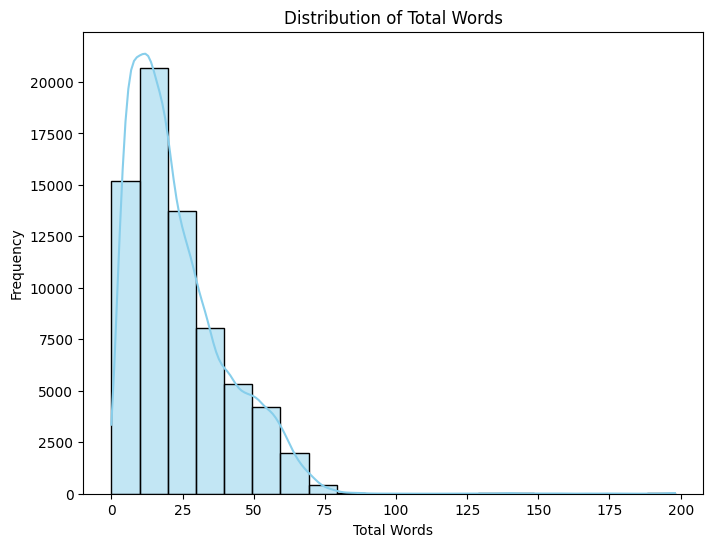

In [17]:
# plot distribution of total words
plt.figure(figsize=(8, 6))
sns.histplot(data=df_vis, x='total_words', bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Words')
plt.xlabel('Total Words')
plt.ylabel('Frequency')
plt.show()

Diketahui sebaran jumlah kata setiap tweet tidak berdistribusi normal, melainkan sangat condong pada jumlah kata yang lebih sedikit. Berikutnya akan dilihat distribusi untuk masing-maisng sentiment.

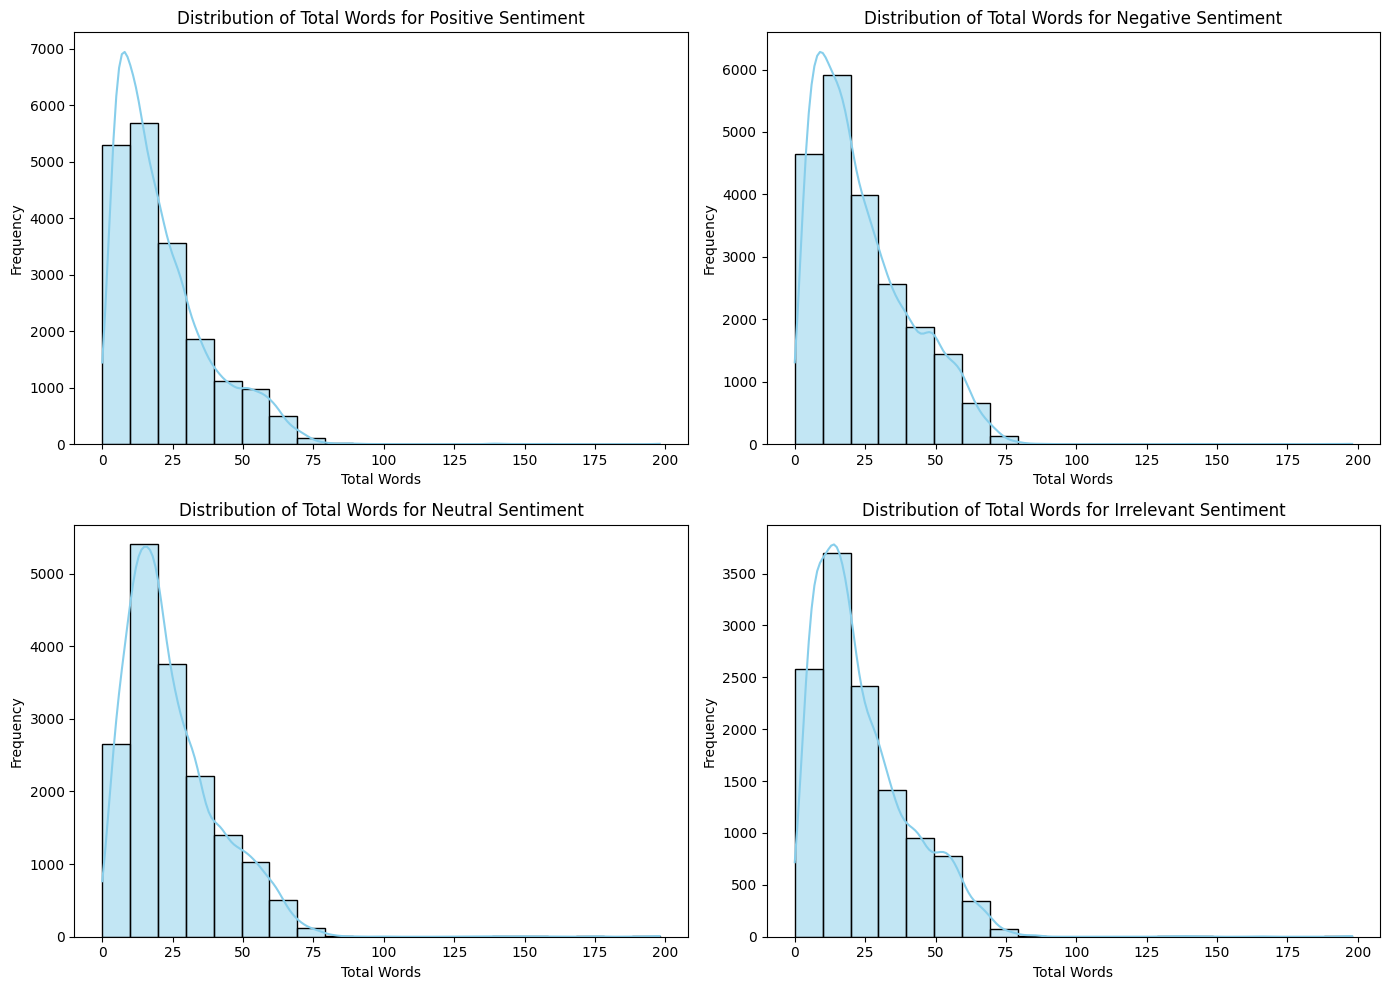

In [18]:
# total words distribution in each sentiment category
sentiment_categories = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

# subplots for each sentiment category
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# iterate to each sentiment category and create histogram plot
for i, ax in enumerate(axes.flatten()):
    sentiment_category = sentiment_categories[i]
    sns.histplot(data=df_vis[df_vis['sentiment'] == sentiment_category], x='total_words', bins=20, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Distribution of Total Words for {sentiment_category} Sentiment')
    ax.set_xlabel('Total Words')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Diketahui bahwa keempat sentiment juga memiliki **sebaran jumlah kata yang serupa**, **Disribusi data tidak merata**, dan condong pada jumlah kata yang lebih sedikit. Untuk melihat angka yang lebih spesifik, selanjutnya akan dihitung nilai tengahnya. Nilai tengah yang lebih representatif adalah nilai median.

In [19]:
# Calculate median total_words for each sentiment category
median_total_words = df_vis.groupby('sentiment')['total_words'].median()
print("Median Total Words in Each Sentiment Category:")
print(median_total_words)

Median Total Words in Each Sentiment Category:
sentiment
Irrelevant    19.0
Negative      20.0
Neutral       20.0
Positive      17.0
Name: total_words, dtype: float64


Diperoleh hasil bahwa orang2 cenderung membuat tweet dengan jumlah kata yang lebih banyak pada sentiment negatif dan netral, sedangkan kata yang lebih sedikit untuk sentimen yang positif saat dibandingkan dengan tweet terkait game yang tidak relevan. Selanjutnya akan ditelusuri kata yang menggambarkan sentiment tersebut menggunakan tampilan wordcloud.

Asumsi alasan terkait jumlah kata pada sentiment:
- Negative: jumlah kata yang banyak (20) dapat disebabkan dari pengguna yang ingin meulapkan emosi atas ketidaknyamanan yang dirasakan saat bermain game
- Neutral: jumlah kata juga banyak (20) karena pengguna memberikan penilai yang objektif dari pros dan cons
- Irrelevant: jumlah kata cukup banyak (19) karena membuat tweet dengan konteks lain, seperti promosi channel streaming, tweet spam hastag atau mention, dll.
- Positive: jumlah kata lebih rendah (17) karena emosi pengguna tenang dan dalam menuliskan tweet dengan bahasa yang tersusun baik dan tidak impulsif.

### Wordcloud

#### Secara Keseluruhan

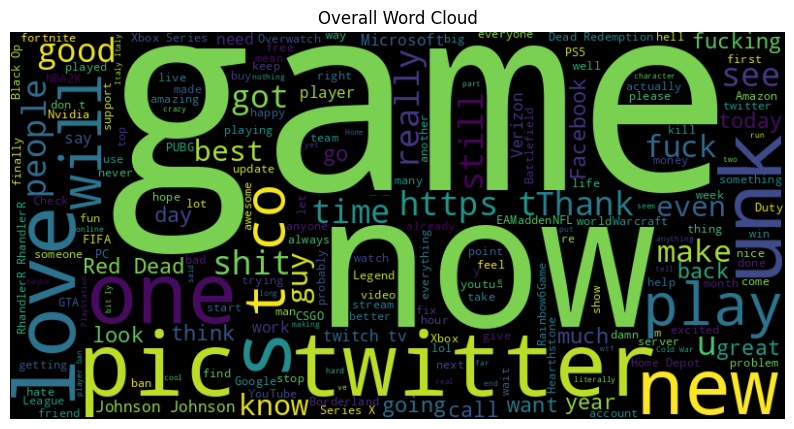

In [20]:
text_combined = ' '.join(df_vis['tweet'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Overall Word Cloud')
plt.axis('off')
plt.show()

Dengan melihat tampilan word cloud diperoleh insight bahwa:

*   Tampilan wordcloud didominasi dengan kata yang kurang relevan untuk menunjukan sentiment seperti game, twitter, play, now, new.
*   Masih ditemui adanya karakter yang tidak jelas ('y', 't', 're', '_ _')
*   Masih ditemui url 'https'
*   Kata-kata belum dalam bentuk dasar nya
*   Perlu dilakukan pengurangan stop word seperti game, unk, dan lainnya.

Masih ditemui karakter-karakter yang tidak berguna untuk menampilkan sentimen dari para pengguna. Maka, selanjutnya diselidiki wordcloud pada setiap sentiment.

##### Untuk setiap sentiment

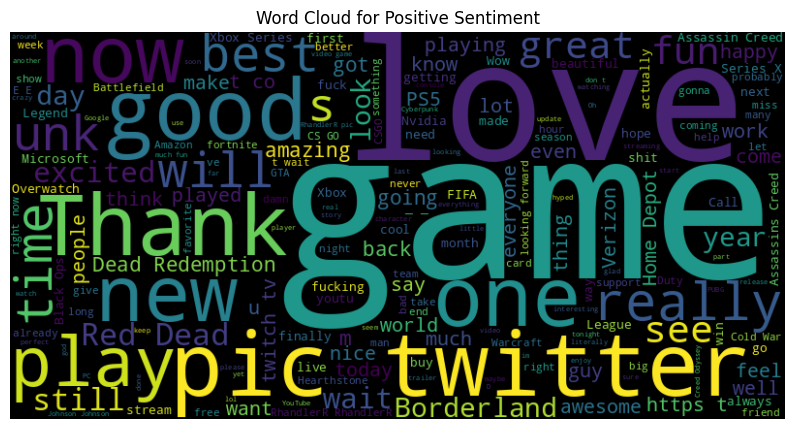

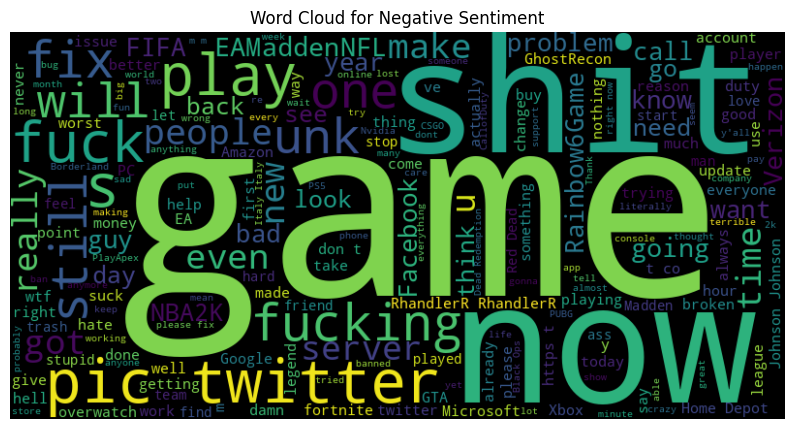

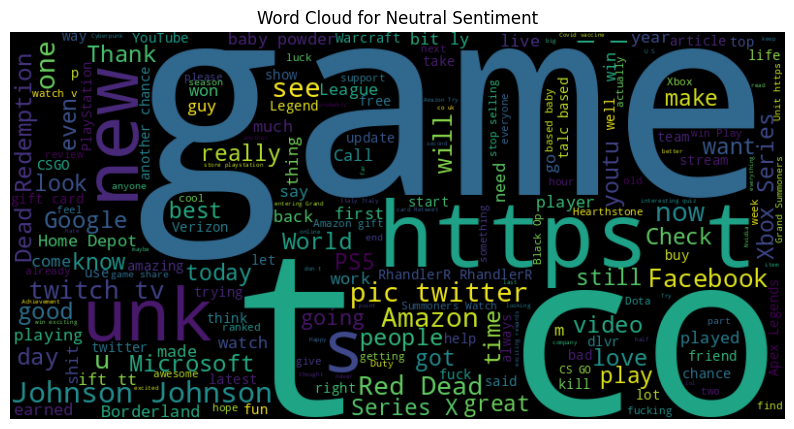

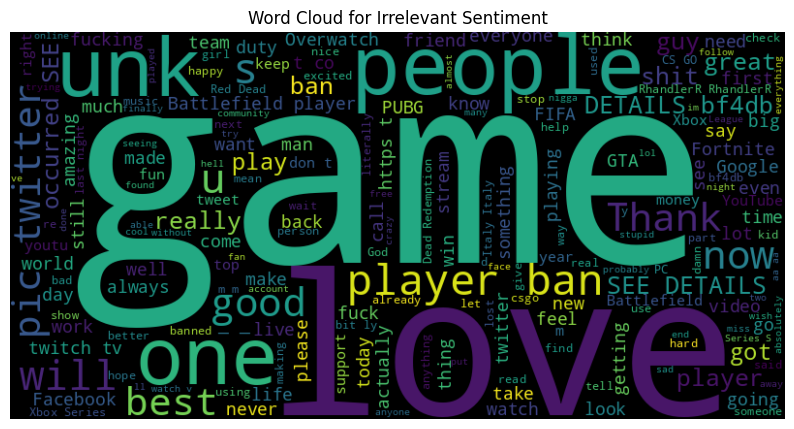

In [21]:
for sentiment_category in sentiment_categories:
    #select data for each sentiment
    text_combined = ' '.join(df_vis[df_vis['sentiment'] == sentiment_category]['tweet'])

    # word cloud the sentiment
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_combined)

    # display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_category} Sentiment')
    plt.axis('off')
    plt.show()


Dari tampilan data diperoleh bahwa:
* Game merupakan suatu kata yang paling mendominasi di setiap sentiment sehingga tidak menunjukan suatu makna. Hal ini menunjukan potensi kata 'game' sebagai stop word. Kata game akan dieliminasi.
* Pada word cloud terlihat ada beberapa jenis hyperlink, dan perlu tangani semua jenis hyperlink yang ada.

Positive Sentiment
* Cenderung didominasi dengan kata pujian Love, Thank, Good, best, great
* Kata shit dan fucking terdapat dalam positive sentiment, hal tersebut terjadi karene kata terebut memiliki makna ganda. Akan tetapi dapat membuat kerancuan sebab kata tersebut adalah kata yang mendominasi di negative sentiment.
* Terdapat stop word t co, t, m, ve, a a
* Terdapat kata yang belum dalam bentuk dasarnya (hyped, getting, coming)
* Terdapat hyperlink ditandai terdeteksinya kata https

Negative Sentiment
* Cenderung didominasi dengan kata makian fuck, shit, dll.
* Terdapat tampilan kata now yang jauh lebih besar dibanding dengan sentiment positif. Dapat menandakan bahwa ada yang perlu di perbaiki sekarang (dikombinasikan dengan fix). atau game yang sekarang jelek (dikombinasikan dengan kata kasar)
* Terdapat stop word s, u, re
* Terdapat kata yang belum dalam bentuk dasarnya (fucking, going, played, player)
* Terdapat hyperlink ditandai terdeteksinya kata https

Neutral Sentiment
* Cenderung didominasi dengan kata yang lebih general, tidak ada kata pujian dan makian yang signifikan
* Terdapat stop word t, tt, re, co
* Terdapat kata yang belum dalam bentuk dasarnya (player, played, earned)
* Terdapat hyperlink ditandai terdeteksinya kata https dan bit ly

Irrelevant Sentiment
* Cenderung didominasi dengan kata yang lebih general, tetapi tidak terlihat ada kata-kata dominan yang berkaitan dengan game atau pun platform streaming.
* Terdapat stop word t, u
* Terdapat kata yang belum dalam bentuk dasarnya (details, player, occurred)


Kata-kata yang mendominasi secara garis besar sudah sesuai dengan sentimentnya, tetapi masih kotor, tertutup oleh kata yang kurang relevan, maka akan dilakukan text preprocessing.

## Feature Engineering

### Text Preprocessing

Ada pun tujuan dari teks preprocessing adalah untuk membuat token jadi seragam, dan mengurangi token yang kurang relevan menggambarkan sentiment sehingga dihasilkan vocabulary yang lebih ***compact*** dan **representatif**

Berikut adalah perlakuan yang diterapkan pada text preprocessing berserta alasannya:

Expand contractions:

dilakukan untuk memperbaiki singkatan kata-kata dalam bahasa inggris yang menggunakan petik tunggal seperti don't karena kata not mengandung makna negasi yang kuat. Selain itu pada proses ini juga akan dilakukan pembetulan kata yang informal seperti wanna dan gonna untuk meminimalisasi size vocab.
    
Case folding:

dilakukan untuk mengubah token jadi lowercase, sehingga meminimalisasi banyaknya vocab akibat variasi huruf kapital.
  
Mention removal:

dilakukan penghapusan mention sebab mention tidak menunjukan setau sentimen yang bermakna, dan hanya akan membuat vocab semakin besar.

Hashtags removal:

dilakukan penghapusan hastag sebab hastag tidak menunjukan sentiment yang bermakna. hastag yang terdapat pada tweet cenderung hanya untuk highlight konten dan memberi label agar lebih mudah ditemukan dalam pencarian.

Newline removal (\n):

dilakukan penghapusan newline untuk memastikan minimalisasi noise akibat token yang tidak diperlukan dalam penentuan sentiment

Whitespace removal:

dilakukan penghapusan whitespce juga untuk meminimalisasi noise akibat token yang tidak diperlukan dalam penentuan sentiment.

URL removal:

dilakukan penghapusan URL sebab URL tidak menunjukan sentiment yang bermakna. Url yang terdapat pada tweet hanya akan jadi noise, dan terbaca sebagai setau token unik untuk setiap url nya, Hal tersebut akan membuat vocab membengkak.

Non-letter removal (emoticon, symbol):

dilakuan untuk meminilisasi token yang tidak diperlukan karena emoticon dan symbol kurang relevan untuk menunjukan sentiment tweet.

Stopwords removal:

dilakukan penghapusan stop word, kata yang paling sering muncul dan kata yang jarang muncul. Sebab hal tersebut akan mempengaruhi siginifikasi model. Hal terebut sangat perlu diterapkan agar kata-kata yang kurang bermakna dieliminasi dan membuat vocab yang lebih compact.

Lemmatizing:

Dilakukan pengubahan kata menjadi bentuk dasarnya agar size vocab menjadi lebih compact. Melalui perbandingan hasil dengan metode Stemming, diperoleh hasil bahwa lemmatize berhasil menunjukan hasil kata dasar yang lebih konsisten daripada stemming, sehingga dipilih cara Lemmatizing.


In [22]:
# make expand contractions function to encounter contranction and other informal word
def expand_contractions(sentence):
    #change certain word
    sentence = re.sub(r"can't", "can not",sentence)
    sentence = re.sub(r"y'all", "you all",sentence)
    sentence = re.sub(r"wanna", " want to",sentence)
    sentence = re.sub(r"im", "i am",sentence)
    sentence = re.sub(r"gotta", " got to",sentence)
    sentence = re.sub(r"go ta", " got to",sentence)
    # Tokenize the sentence into words
    tokens = word_tokenize(sentence)
    # Define contraction mapping
    contractions_mapping = {"n't": " not", "'s": " is", "'m": " am", "'re": " are", "'ll": " will", "'ve": " have", "'d": " would", "got ta": " got to"}
    # Expand contractions
    expanded_tokens = [contractions_mapping.get(token, token) for token in tokens]
    # Join the tokens back into a sentence
    expanded_sentence = ' '.join(expanded_tokens)
    return expanded_sentence

In [23]:
# make variable for additional stop word
additional_stopwords = ['oh', 'unk','com', 'ti', 'game', 'db', 'bf', 'c go', 'unk', 'p', 't co', 'm', 've', 'a a', 's', 'u', 're', 'tt', 're', 'co', 'u']

In [24]:
#make sure there is no NaN value in tweet document
df_test.dropna(subset=['tweet'], inplace=True)

In [50]:
# make variable for additional stop word
additional_stopwords = ['unk','com', 'ti', 'game', 'db', 'bf', 'c go', 'unk', 'p', 't co', 'm', 've', 'a a', 's', 'u', 're', 'tt', 're', 'co', 'u']

# Define Stopwords

stpwds_en = list(set(stopwords.words('english')))
stpwds_en.append(additional_stopwords)

# Define Lemmatiizng

lemmatizer = WordNetLemmatizer()

In [26]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Expand contractions
  text = expand_contractions(text)

  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)
  text = re.sub("@ [A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)
  text = re.sub(r"twitch.tv\S+", " ", text)
  text = re.sub(r"twitch tv\S+", " ", text)
  text = re.sub(r"pic.twitter.com\S+", " ", text)
  text = re.sub(r"dlvr.it\S+", " ", text)
  text = re.sub(r"dfr.it / RMTrgF", " ", text)
  text = re.sub(r"dlvr.it\S+", " ", text)
  text = re.sub(r"dlvr.it \S+", " ", text)


  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_en ]
  tokens = [word for word in tokens if word not in additional_stopwords]

  # Lemmatizing
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

  # Applying Text Preprocessing to the Dataset
df['tweet_processed'] = df['tweet'].apply(lambda x: text_preprocessing(x))
df_test['tweet_processed'] = df_test['tweet'].apply(lambda x: text_preprocessing(x))

df

sentiment                                              tweet  \
0      Positive  im getting on borderlands and i will murder yo...   
1      Positive  I am coming to the borders and I will kill you...   
2      Positive  im getting on borderlands and i will kill you ...   
3      Positive  im coming on borderlands and i will murder you...   
4      Positive  im getting on borderlands 2 and i will murder ...   
...         ...                                                ...   
74677  Positive  Just realized that the Windows partition of my...   
74678  Positive  Just realized that my Mac window partition is ...   
74679  Positive  Just realized the windows partition of my Mac ...   
74680  Positive  Just realized between the windows partition of...   
74681  Positive  Just like the windows partition of my Mac is l...   

                                         tweet_processed  
0                              getting borderland murder  
1                                     coming border kill  
2                                getting borderland kill  
3                               coming borderland murder  
4                              getting borderland murder  
...                                                  ...  
74677  realized window partition mac like year behind...  
74678  realized mac window partition year behind nvid...  
74679  realized window partition mac year behind nvid...  
74680  realized window partition mac like year behind...  
74681  like window partition mac like year behind dri...  

[69769 rows x 3 columns]

### Target encoding

In [27]:
# Display Target

df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [28]:
# Change Target into Number

df['label'] = df['sentiment'].replace({'Irrelevant' : 0, 'Negative' : 1, 'Neutral' : 2, 'Positive' : 3})
df_test['label'] = df_test['sentiment'].replace({'Irrelevant' : 0, 'Negative' : 1, 'Neutral' : 2, 'Positive' : 3})
df

sentiment                                              tweet  \
0      Positive  im getting on borderlands and i will murder yo...   
1      Positive  I am coming to the borders and I will kill you...   
2      Positive  im getting on borderlands and i will kill you ...   
3      Positive  im coming on borderlands and i will murder you...   
4      Positive  im getting on borderlands 2 and i will murder ...   
...         ...                                                ...   
74677  Positive  Just realized that the Windows partition of my...   
74678  Positive  Just realized that my Mac window partition is ...   
74679  Positive  Just realized the windows partition of my Mac ...   
74680  Positive  Just realized between the windows partition of...   
74681  Positive  Just like the windows partition of my Mac is l...   

                                         tweet_processed  label  
0                              getting borderland murder      3  
1                                     coming border kill      3  
2                                getting borderland kill      3  
3                               coming borderland murder      3  
4                              getting borderland murder      3  
...                                                  ...    ...  
74677  realized window partition mac like year behind...      3  
74678  realized mac window partition year behind nvid...      3  
74679  realized window partition mac year behind nvid...      3  
74680  realized window partition mac like year behind...      3  
74681  like window partition mac like year behind dri...      3  

[69769 rows x 4 columns]

In [29]:
# Target Distribution

df['label'].value_counts()

1    21237
3    19138
2    17110
0    12284
Name: label, dtype: int64

## EDA (setelah text preprocesing)

In [30]:
df_final = df.copy()

### Sebaran Jumlah Kata Setelah Preprocessing

In [31]:
# add new column to store word count of document
df_final['total_words'] = df_final['tweet_processed'].apply(lambda x: len(nltk.word_tokenize(x)))
df_final

sentiment                                              tweet  \
0      Positive  im getting on borderlands and i will murder yo...   
1      Positive  I am coming to the borders and I will kill you...   
2      Positive  im getting on borderlands and i will kill you ...   
3      Positive  im coming on borderlands and i will murder you...   
4      Positive  im getting on borderlands 2 and i will murder ...   
...         ...                                                ...   
74677  Positive  Just realized that the Windows partition of my...   
74678  Positive  Just realized that my Mac window partition is ...   
74679  Positive  Just realized the windows partition of my Mac ...   
74680  Positive  Just realized between the windows partition of...   
74681  Positive  Just like the windows partition of my Mac is l...   

                                         tweet_processed  label  total_words  
0                              getting borderland murder      3            3  
1                                     coming border kill      3            3  
2                                getting borderland kill      3            3  
3                               coming borderland murder      3            3  
4                              getting borderland murder      3            3  
...                                                  ...    ...          ...  
74677  realized window partition mac like year behind...      3           11  
74678  realized mac window partition year behind nvid...      3           10  
74679  realized window partition mac year behind nvid...      3           10  
74680  realized window partition mac like year behind...      3           14  
74681  like window partition mac like year behind dri...      3           10  

[69769 rows x 5 columns]

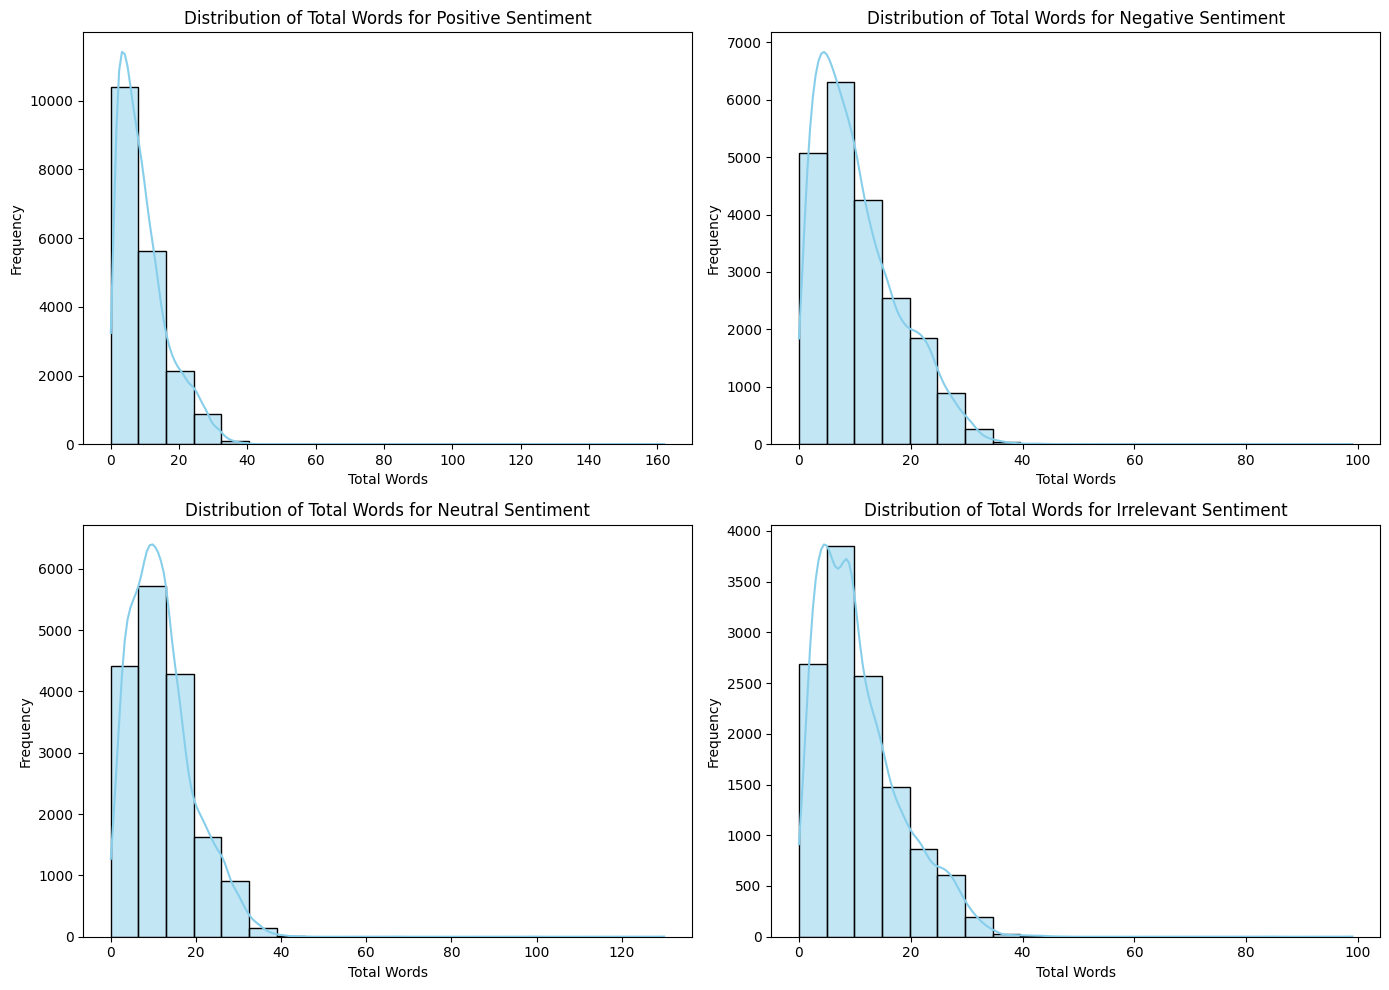

In [32]:
# subplots for each sentiment category
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# iterate to each sentiment category and create histogram plot
for i, ax in enumerate(axes.flatten()):
    sentiment_category = sentiment_categories[i]
    sns.histplot(data=df_final[df_final['sentiment'] == sentiment_category], x='total_words', bins=20, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Distribution of Total Words for {sentiment_category} Sentiment')
    ax.set_xlabel('Total Words')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [33]:
# Calculate median total_words for each sentiment category
median_total_words = df_final.groupby('sentiment')['total_words'].median()
print("Median Total Words in Each Sentiment Category:")
print(median_total_words)

Median Total Words in Each Sentiment Category:
sentiment
Irrelevant     9.0
Negative       9.0
Neutral       11.0
Positive       8.0
Name: total_words, dtype: float64


Setelah mengeliminasi kata-kata yang tidak relevan dan tidak menggambarkan sentiment, ternyata jumlah kata yang pada masing-masing sentiment jauh lebih rendah. Highlight dari data ini adalah ternyata sentiment negative memiliki jumlah kata yang cukup sedikit (9), menandakan bahwa sebenarkan pada tweet negatif, pengguna cenderung menulis ucapan yang kosong. Ucapannya banyak padahal intinya sedikit.

### Word Cloud Setelah Preprocessing

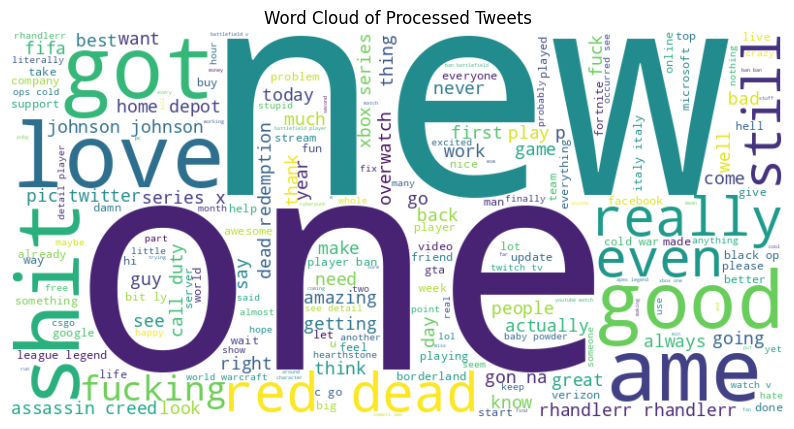

In [34]:
# Combine all processed tweets into a single string
text_combined = ' '.join(df_final['tweet_processed'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Processed Tweets')
plt.axis('off')
plt.show()

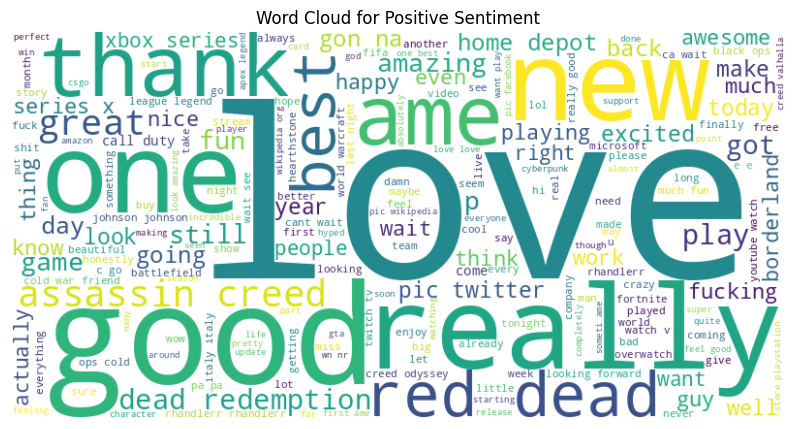

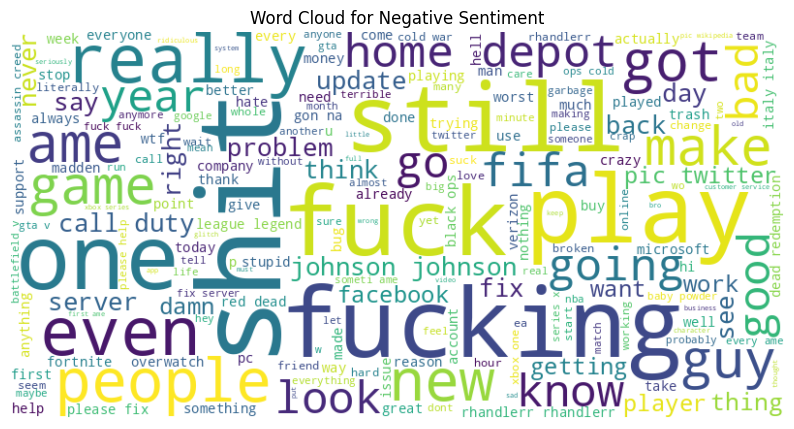

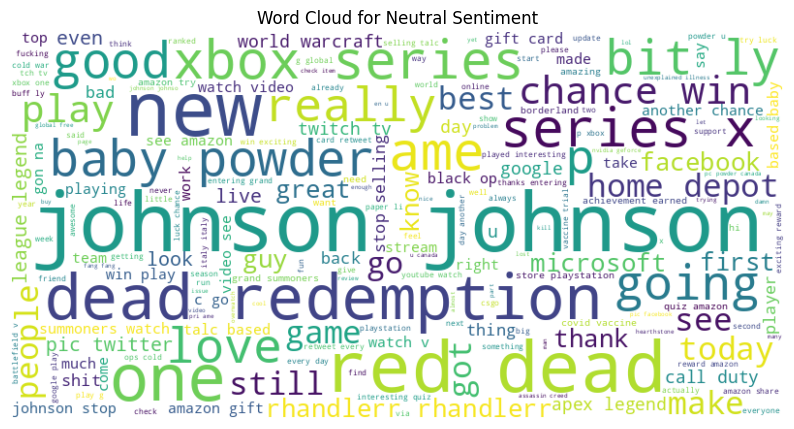

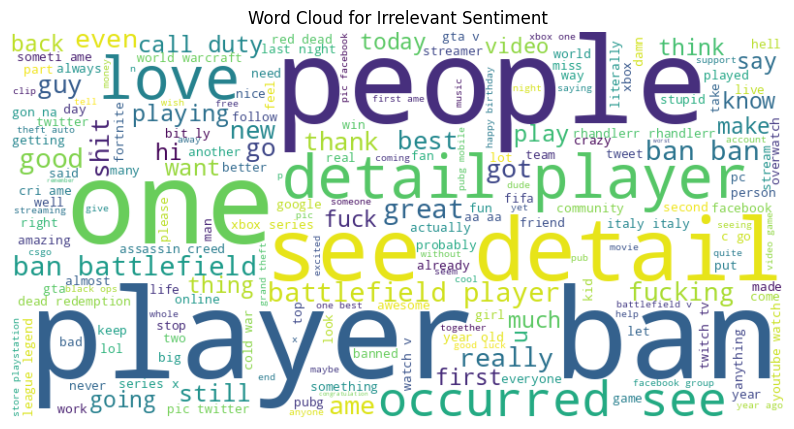

In [35]:
# Generate word cloud for each sentiment category
for sentiment_category in sentiment_categories:
    # Combine all processed tweets for the current sentiment category into a single string
    text_combined = ' '.join(df_final[df_final['sentiment'] == sentiment_category]['tweet_processed'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

    # Display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_category} Sentiment')
    plt.axis('off')
    plt.show()

Setelah teks preprocessing dihasilkan kata dominan yang lebih jelas pada masing-masing sentiment, dan ditampilkan kata yang menggambarkan sentimen yang tepat.

Adapun saya ketahui bahwa teks preprocessing ini belum sempurna, nama game seperti CSGO, Dead Redemption, World Warcraft, Borderland saya anggap adalah word stop krn kurang relevan unutk menggabarkan sentimen, begitupun dengan nama username seperti johnson&johnson yang gagal dieliminasi. Untuk memaksimalkan waktu yang terbatas ini saya tidak akan perbaiki, namun akan saya jadikan alasan pada analisis performa model.

## Model Building

### Splitting data

In [36]:
# Data Splitting

X_train, X_val, y_train, y_val = train_test_split(df.tweet_processed,
                                                    df.label,
                                                    test_size=0.10,
                                                    random_state=20,
                                                    stratify=df.label)
X_test = df_test['tweet_processed']
y_test = df_test['label']

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)

Train Size :  (62792,)
Val Size   :  (6977,)


In [37]:
#one hot encode target
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

### Text vectorization

In [38]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.fit_transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<62792x23784 sparse matrix of type '<class 'numpy.int64'>'
	with 620113 stored elements in Compressed Sparse Row format>

In [39]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  11110
Maximum Sentence Length :  162 tokens


In [41]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=int(max_sen_len*0.7),
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

Pada tahap ini dilakukan setting vektorisasi sesuai dengan literatur, bahwa nilai untuk panjang sequence output dapat efektif dengan 70% persen dari kata terpanjang, 162.

### Word embedding

In [42]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

Pada tahapan ini dilakukan embeding untuk mengambil vektor yang telah dibuat lalu dibuat susunan vocab dari frekuansi mungcukl paling banyak. dan diatur dimensi out dengan nilai 128 dengan tujuan nilai yang besar ini dapat hubungan antara matriks setiap vocab.

## Model Training

### ANN before improvement

In [43]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()

model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(4, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

model_lstm_1.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(
    X_train, y_train_ohe,
    epochs=25,  batch_size=32,
    validation_data=(X_val, y_val_ohe))

Epoch 1/25
1963/1963 [==============================] - 186s 92ms/step - loss: 0.8767 - accuracy: 0.6577 - val_loss: 0.6531 - val_accuracy: 0.7612
Epoch 2/25
1963/1963 [==============================] - 176s 90ms/step - loss: 0.4652 - accuracy: 0.8383 - val_loss: 0.5072 - val_accuracy: 0.8207
Epoch 3/25
1963/1963 [==============================] - 177s 90ms/step - loss: 0.3340 - accuracy: 0.8825 - val_loss: 0.4757 - val_accuracy: 0.8345
Epoch 4/25
1963/1963 [==============================] - 176s 90ms/step - loss: 0.2693 - accuracy: 0.9034 - val_loss: 0.4717 - val_accuracy: 0.8446
Epoch 5/25
1963/1963 [==============================] - 176s 90ms/step - loss: 0.2239 - accuracy: 0.9184 - val_loss: 0.4677 - val_accuracy: 0.8578
Epoch 6/25
1963/1963 [==============================] - 175s 89ms/step - loss: 0.1913 - accuracy: 0.9301 - val_loss: 0.4703 - val_accuracy: 0.8646
Epoch 7/25
1963/1963 [==============================] - 176s 90ms/step - loss: 0.1675 - accuracy: 0.9379 - val_loss: 0

#### Model Performance Evaluation

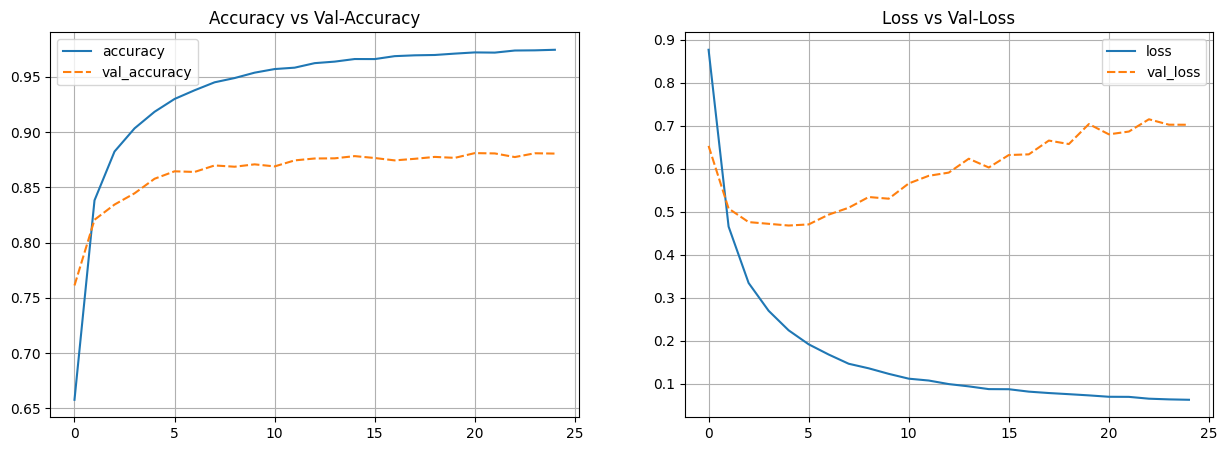

In [44]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### Model Analysis

Narasi:

Agar lebih compact, dibuat rangakaian model dengan menyematkan proses vektorisasi dan embedding sesuai dengan set up yang sudah diadjust. lalu dilanjutkan dengan proses pada 2 hidden layer dengan metode long term short memory untuk memproses data sequential dengan jumlah neuron yang semakin sedikit pada layer selanjutnya. Pada akhirnya dilakukan output dengan aktivator softmax dengan tujuan dapan dihasilkan probabilitas true untuk masing-masing kategori sentiment.

Alasan terkait set up model:

*   Dipilih Neural Network LTSM karena model ini cocok dengan data saya yang berbentuk text dan memiliki size yang besar. Saya juga juga memakai LTSM agar menghindari informasi data yang hilang saat perpindahan nya antar neuron. Adapun kelemahannya waktu runtime yang lebih lama dibanding GRU, jadi saya imbangin dengan mengurangi setting hyper parameter lain.
*   Dipilih sequential API karena ingin mengaplikasikan rangkaian yang sederhana dengan ekspektasi runtime yang lebih rendah
*   Diterapkan jumlah hidden layer dan neuron sedikit, untuk meminimalisasi runtime
*   Diterapkan 25 epooch dalam rangka meminimalisasi runtime
*   Tidak digunakan transfer learning untuk melihat performance model sebelum dioptimalisasi

Analisis hasil performance model:

* Faktor penyebab:

adapun model ANN ini dikatakan sensitif dengan adanya outlier, data imbalance, maka faktor yang menyebabkan performance yang jelek antara lain:

1. perbandingan kelas target tidak balance
2.  masih terdeteksi stop word atau kata-kata yang kuranhg relevan dengan analisis target.

* Grafik Loss vs Val Loss

Performance model: over fit

Model dikatakan demikian karena nilai validation bagus pada bagian awal-awal saja, dan meningkat seiring berjalannya proses training menandakan semakin lama model akan hasilkan model yang tidak bagus. Bentuk kurva cenderung bagus untuk data train, menandakan data di proses terlalu spesifik untuk data train saja, saat diaplikasikan untuk validation model tidak bisa kerjakan dengan baik sehingga lossnya semakin tinggi.

* Grafik Accuracy vs Val Accuracy

Performance model: over fit

Sama seperti penjelasan Loss, model dikatakan demikian karena nilai akurasi sama-sama meningkat pada bagian awal-awal saja, dan seiring berjalannya proses training, akurasi validation stuck pada nilai tertentu. Bentuk kurva cenderung bagus untuk data train, menandakan data di proses terlalu spesifik untuk data train saja, saat diaplikasikan untuk validation model tidak bisa kerjakan dengan baik sehingga lossnya semakin tinggi.

DUGAAN PENYEBAB: dari grafik hasil yang demikian didapat dugaan bahwa ada kemungkinan data validation kurang random, jadi validation mengambil bagian data train dengan jenis kasus yang sama, sehingga pada train tidak ada gambaran pengalaman untuk mennyelesaikan kasus di validation.

Kelebihan dan kekurangan dengan set up model seperti ini:

Kelebihan:
* Waktu runtime dibuat jadi sesingkat mungkin
* Diterapkan model yang cocok dengan data yang ada (hasil belajar model lebih baik)

Kekurangan
* Pengolahan data jadi terlalu general dan kurang mendalam (tipe sequential, jumlah neuron dan jumlah hidden layer sedikit)
* Kesempatan model untuk belajar dan memperbaiki hasil juga terbatas (epoch sedikit)

Next Improvement:

Ada baiknya dilakukan splitting dengan random state lebih tinggi, menganalisa ulang teksprosesing, eliminasi stop word, penggunaan transfer learning, dan mengatur neuron dan hidden layer.

Untuk menyesuaikan dengan **waktu yang terbatas**, hanya dilakukan transfer learning, dan adjust hidden layer, dan jumlah neuron.

### ANN after improvement (using Transfer Layer)

In [45]:
# Download the Embedding Layer

url = "https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim128/versions/1"

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [48]:
# Model Training using LSTM with Transfer Learning
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Bidirectional(LSTM(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Dense(4, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_lstm_2_hist = model_lstm_2.fit(
    X_train, y_train_ohe,
    epochs=25,  batch_size=32,
    validation_data=(X_val, y_val_ohe))

Epoch 1/25
1963/1963 [==============================] - 270s 133ms/step - loss: 1.3515 - accuracy: 0.3359 - val_loss: 1.3230 - val_accuracy: 0.3712
Epoch 2/25
1963/1963 [==============================] - 249s 127ms/step - loss: 1.3255 - accuracy: 0.3765 - val_loss: 1.3152 - val_accuracy: 0.3774
Epoch 3/25
1963/1963 [==============================] - 253s 129ms/step - loss: 1.3156 - accuracy: 0.3884 - val_loss: 1.2979 - val_accuracy: 0.4013
Epoch 4/25
1963/1963 [==============================] - 251s 128ms/step - loss: 1.3065 - accuracy: 0.3977 - val_loss: 1.2894 - val_accuracy: 0.4078
Epoch 5/25
1963/1963 [==============================] - 252s 129ms/step - loss: 1.2977 - accuracy: 0.4070 - val_loss: 1.2754 - val_accuracy: 0.4224
Epoch 6/25
1963/1963 [==============================] - 252s 128ms/step - loss: 1.2881 - accuracy: 0.4165 - val_loss: 1.2683 - val_accuracy: 0.4307
Epoch 7/25
1963/1963 [==============================] - 252s 129ms/step - loss: 1.2801 - accuracy: 0.4241 - val_

#### Model Performance Evaluation

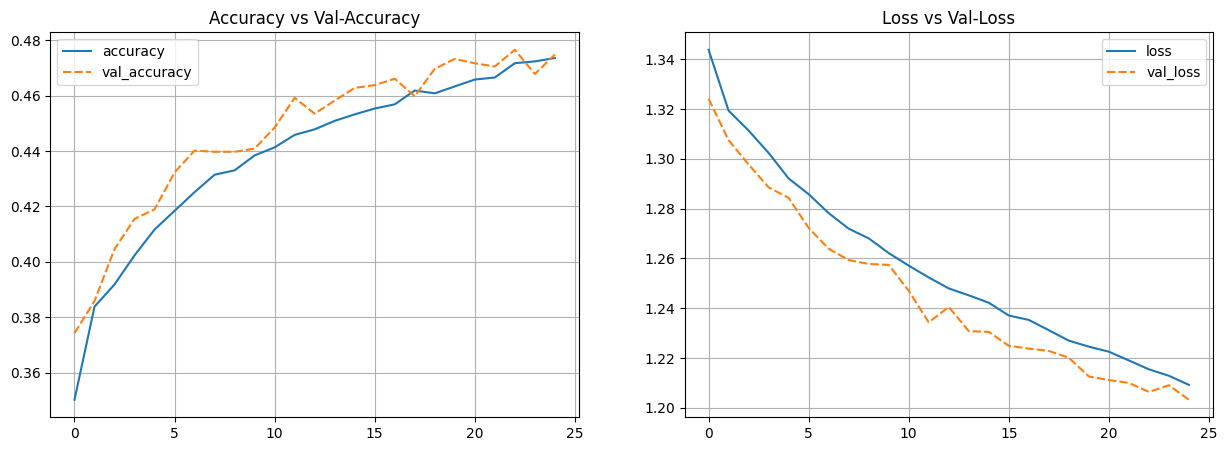

In [47]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### Model Analysis

Improvement yang sudah dilakukan:

*   Menggunakan Transfer Learning
*   Menambah jumlah neuron dan hidden layer
*   Menambah callback
*   Mengubah nilai drop out

Alasan terkait set up model:

*   Dipilih Transfer leraning model dapat belajar lebih baik dari gambaran yang sudah didapat.
*   Dipilih penambahan jumlah neuron dan hidden layer agar alur informasi yang diolah semakin banyak dan menghasilkan nilai prediksi yang lebih akurat
*   Diterapkan call back untuk mengefektifkan runtime. Sehingga model train yang berjalan cukup sampai di titik yang dirasa sudah menunjukan hasil yang optimal
*   Diterapkan droppout, unutk mengeliminasi informasi yang tidak ingin dilanjutkan ke neuron berikutnya

Analisis hasil performance model:

* Faktor penyebab:

setelah improve ternyata dihasilkan model yang underfit, hal tersebut dapat disebabkan, nilai drop out yang terlalu besar jadi ada informasi penting yang dieliminasi, dan epoch yang terlalu singkat sehingga waktu belajar yang singkat sehingga tidak bisa melihat titik konstan.

* Grafik Loss vs Val Loss

Performance model: under fit

Model dikatakan underfit karena grafik menunjukan sutau penurunan nilai, kita belum atau apakah di bagian akhir akan menghasilkan loss yang sama-sama rendah atau tidak. Namun gap antara val loss dan loss semakin tipis, menunjukan potensi bahwa jika epoch ditingkatkan akan mencapai titik konstan yang sama juga.

* Grafik Accuracy vs Val Accuracy

Performance model: under fit

Sama seperti penjelasan Loss, model dikatakan underfit karena grafik menunjukan suatu peningkatan nilai, kita belum atau apakah di bagian akhir akan menghasilkan akurasi yang sama-sama tinggi atau tidak. Namun hal yang jelas Akurasi training dan validation sama-sama lebih rendah, hanya 48%. Hal tersebut berarti, jika model diterapkan pada kasus test set atau pun dunia nyata dia belum bisa menghasilkan prediksi yang baik, masih seperti menebak-nembak jenis sentimen.

DUGAAN PENYEBAB: dari grafik hasil yang demikian didapat dugaan bahwa ada kemungkinan model buytuh waktu belajar yang lebih untuk dihasilkan model yang bagus.

Kelebihan dan kekurangan dengan set up model seperti ini:

Kelebihan:
* Gap antara validation dan train semakin kecil

Kekurangan
* belum bisa mengklasifikasikan model dengan baik

Next Improvement:
Ada baiknya dilakukan pengaturan ulang terkait nilai drop out


Kesimpulan: setelah dilakukan improvement, model menjadi under fit, namu ada potensi untuk menjadi goodfit dengan menambah waktu eepoch, dan runtime berhasil dipersingkat dengan penggunaan transfer learning.

## Model Prediction

In [51]:
# Evaluate test-set

result = model_lstm_2.evaluate(X_test, y_test_ohe)
result

32/32 [==============================] - 1s 28ms/step - loss: 1.1633 - accuracy: 0.5125


[1.1633192300796509, 0.5125125050544739]

## Model Prediction Evaluation

In [52]:
# Define the Class Names

class_names = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

In [53]:
# Check the performance of test-set

# Get the probability
y_pred_proba = model_lstm_2.predict(X_test)

# Get class with maximum probability
y_pred = np.argmax(y_pred_proba, axis=-1)

# Display Classification Report
print(classification_report(y_test, y_pred)) #target_names=np.array(class_names)

32/32 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           0       0.64      0.15      0.24       172
           1       0.48      0.74      0.58       266
           2       0.55      0.47      0.51       285
           3       0.51      0.57      0.54       276

    accuracy                           0.51       999
   macro avg       0.55      0.48      0.47       999
weighted avg       0.54      0.51      0.49       999



Hasil latihan dengan data test juga selaras dengan argumen yang diampaikan sebelumnya bahwa, performace model yang diterbaiki maish under fit, danmodel masih cenderung seperti menebak-nebak jenis sentimen.

## Model Saving

In [54]:
# Model

# Freeze model
model_lstm_2.trainable = False

# Save ANN model
model_lstm_2.save('model_improved', save_format='tf')

## Overall analysis

Pada kasus ini telah dibuat suatu model machine learning menggunakan neural network pada suatu data teks. Model ini dikerjakan dengan cara melakukan teksprocesing untuk membersihkan data dari kata-kata yang relevan, selanjutnya penyiapan data melalui proses vectorization dan embedding, kemudian diterapkan pelatihan dengan model neural network long term short memory agar lebih cocok pada data sequential berbentuk teks dengan size besar.

Adapun kelebihan  dari model ini adalah model dapat membuat borderline pemisah antar klasifikasi yang lebih fleksibel sehingga lebih dapat mengikuti lika-liku tata bahasa yang kompleks. Ada pun kelemahannya adalah model ini sangat rentan terhadap outlier, data imbalance, data preprocessing. Rintangan tersebut lah yang menjadi tantangan saya dalam pengerjaan kasus ini. Hasilnya, saya belum bisa menemukan komposisi yang pas untuk mengoptimalkan performa model. Namun, setelah optimalisasi yang saya lakukan saya percaya bahwa ada suatu kesempatan untuk meningkatkan performa jika menambahkan epoch.

Model dinyatakan belum dapat aplikasikan untuk mengenali sentimen pengguna game karena performa masih belum bergitu bagus


Penjelasan performance pada masing-masing metriks:

* Grafik Loss vs Val Loss

Performance model: under fit

Model dikatakan underfit karena grafik menunjukan sutau penurunan nilai, kita belum atau apakah di bagian akhir akan menghasilkan loss yang sama-sama rendah atau tidak. Namun gap antara val loss dan loss semakin tipis, menunjukan potensi bahwa jika epoch ditingkatkan akan mencapai titik konstan yang sama juga.

* Grafik Accuracy vs Val Accuracy

Performance model: under fit

Sama seperti penjelasan Loss, model dikatakan underfit karena grafik menunjukan suatu peningkatan nilai, kita belum atau apakah di bagian akhir akan menghasilkan akurasi yang sama-sama tinggi atau tidak. Namun hal yang jelas Akurasi training dan validation sama-sama lebih rendah, hanya 48%. Hal tersebut berarti, jika model diterapkan pada kasus test set atau pun dunia nyata dia belum bisa menghasilkan prediksi yang baik, masih seperti menebak-nembak jenis sentimen.

DUGAAN PENYEBAB: text prepcossing yang dilakukan belum maksimal, dan dari grafik hasil yang demikian didapat dugaan bahwa ada kemungkinan model butuh waktu belajar yang lebih untuk dihasilkan model yang bagus.

Kelebihan dan kekurangan dengan set up model seperti ini:

Kelebihan:
* Gap antara validation dan train semakin kecil

Kekurangan
* belum bisa mengklasifikasikan model dengan baik

Next Improvement:
Ada baiknya dilakukan pengaturan ulang terkait nilai drop out dan parameter dan preprocessing data.